In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.tree import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from skpsl import ProbabilisticScoringList
from xgboost import XGBClassifier

In [2]:
folder = Path("experiments/data/liver_disorders")
folder = Path("data/liver_disorders")

data_bupa = pd.read_csv(folder/"bupa.data", sep=",", header=None, names = ["mcv",
"alkphos",
"sgpt",
"sgot",
"gammagt",
"drinks",
"selector"])

data_bupa= data_bupa.drop(columns=["selector"])
data_bupa["drinks"] = (data_bupa["drinks"] >= 3).astype("int")

costs_bupa = pd.read_csv(folder/"bupa-liver.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_bupa[1] = costs_bupa[1].str.strip(",").astype(float)
costs_bupa.index = costs_bupa.index.str.strip(":")
costs_bupa

,1,2
0,,
mcv,7.27,5.17
alkphos,7.27,5.17
sgpt,7.27,5.17
sgot,7.27,5.17
gammagt,9.86,7.76


In [3]:
X, y = data_bupa.iloc[:,:-1].to_numpy(), data_bupa.iloc[:,-1].to_numpy() 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [4]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5).fit(X_train, y_train)
psl = ProbabilisticScoringList(score_set={-3,-2,-1,1,2,3}, method="brute").fit(X_train,y_train)

In [5]:
def get_bupa_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            if i == 0:
                cost += costs_bupa.iloc[s,0]
            else:
                cost += costs_bupa.iloc[s,1]
        return cost
    else:
        raise TypeError("Alarm")

def predict_with_cost(dt, X_test):
    y_probas = []
    features_pred = []
    cost_pred = []

    for x_test in X_test:
        x_test = x_test.reshape(1,-1)
        y_proba = dt.predict_proba(x_test)
        y_probas.append(y_proba)

        # Get the decision path for the test instance
        decision_path = dt.decision_path(x_test)

        # Get feature indices used at each node
        node_indicator = decision_path.indices
        features_used = dt.tree_.feature[node_indicator]

        # Filter out any -2s, which represent leaf nodes
        features_used = features_used[features_used != -2]
        
        features_pred.append(features_used)
        cost_summand = get_thyroid_cost_for_feature_subset(features_used)
        cost_pred.append(cost_summand)
    return np.asarray(y_proba), cost_pred, features_pred 

In [6]:
def limited_feature_predict(clf, X, max_features):
    """
    Make predictions by limiting the number of features the tree can make.
    
    Parameters:
    clf: Trained decision tree classifier
    X: Feature matrix
    max_splits: Maximum number of features to traverse before making a prediction
    
    Returns:
    predictions: Array of predictions for each sample in X
    """
    tree = clf.tree_
    n_samples = X.shape[0]
    predictions = []
   
    feature_lists = []

    for i in range(n_samples):
        feature_list = []
        node_id = 0  # Start at the root node

        while tree.children_left[node_id] != tree.children_right[node_id]:  # While not a leaf

            # Get the feature to split on and the threshold to compare to
            feature = tree.feature[node_id]

            # Stop if the max number of splits is reached
            if len(set(feature_list + [feature])) > max_features:
                break
            
            feature_list.append(feature)
            threshold = tree.threshold[node_id]

            # Traverse to the left or right child based on feature value
            if X[i, feature] <= threshold:
                node_id = tree.children_left[node_id]
            else:
                node_id = tree.children_right[node_id]

        # After the loop, we are at a node, make a prediction
        # Use the majority class of this node to make a prediction
        predictions.append(tree.value[node_id]) 
        feature_lists.append(feature_list)

    return np.vstack(predictions), feature_lists


In [7]:
briers_psl = []
briers_dt = []

accs_psl = []
accs_dt = []

baccs_psl = []
baccs_dt = []

costs_psl = []
costs_dt = []

num_features = X_train.shape[1]

#X_test = X_train
#y_test = y_train

for i in range(0,num_features):
    y_prob_psl = psl.predict_proba(X_test, k=i)

    print(psl[i].features)
    psl_cost = len(X_test) * get_bupa_cost_for_feature_subset(psl[i].features) 
    print("psl:", psl[i].features)
    print(len(X_test))
    y_prob_dt, used_features = limited_feature_predict(dt, X_test, max_features=i)

    dt_cost = 0

    for feature_subset in used_features:
        dt_cost += get_bupa_cost_for_feature_subset(feature_subset)

    print("dt:", len(used_features), used_features)

    briers_psl.append(brier_score_loss(y_test, y_prob_psl[:,1]))
    briers_dt.append(brier_score_loss(y_test, y_prob_dt[:,1]))

    accs_psl.append(accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
    accs_dt.append(accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

    baccs_psl.append(balanced_accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
    baccs_dt.append(balanced_accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

    costs_psl.append(psl_cost)
    costs_dt.append(dt_cost)


[]
psl: []
87
dt: 87 [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[3]
psl: [3]
87
dt: 87 [[3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3]]
[3, 4]
psl: [3, 4]
87
dt: 87 [[3, 4], [3, 4], [3, 2], [3, 2], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 2

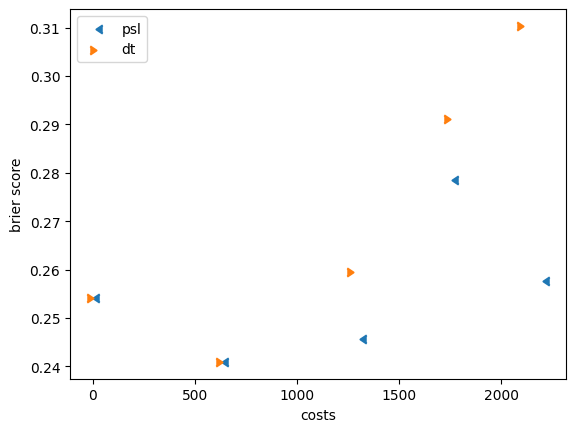

In [8]:
plt.scatter(costs_psl, briers_psl, label="psl", marker=4)
plt.scatter(costs_dt, briers_dt, label="dt", marker=5)

plt.xlabel("costs")
plt.ylabel("brier score")

plt.legend()
plt.show()

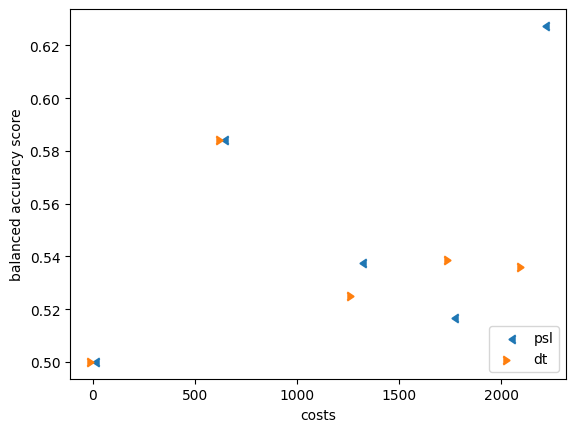

In [9]:
plt.scatter(costs_psl, baccs_psl, label="psl" , marker=4)
plt.scatter(costs_dt, baccs_dt, label="dt", marker=5)

plt.xlabel("costs")
plt.ylabel("balanced accuracy score")

plt.legend(loc="lower right")
plt.show()

In [10]:
for k, pss in enumerate(psl):
    print(f"stage: {k} expected entropy {pss.score(X_train, y_train)}")

stage: 0 expected entropy 0.997223972183649
stage: 1 expected entropy 0.9459007325567687
stage: 2 expected entropy 0.9162097569633334
stage: 3 expected entropy 0.8860948189385073
stage: 4 expected entropy 0.8594818753710849
stage: 5 expected entropy 0.8260430612822317


In [11]:
psl.inspect()

,Stage,Threshold,Feature Index,Score,T = -4,T = -3,T = -2,T = -1,T = 0,T = 1,T = 2,T = 3,T = 4,T = 5,T = 6
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531008,NaN,NaN,NaN,NaN,NaN,NaN
1,1,>33.5000,3.0,3.0,NaN,NaN,NaN,NaN,0.484581,NaN,NaN,0.870968,NaN,NaN,NaN
2,2,>13.5000,4.0,2.0,NaN,NaN,NaN,NaN,0.261905,NaN,0.535135,0.870968,NaN,0.870968,NaN
3,3,>48.5000,1.0,-3.0,NaN,0.205128,NaN,0.509091,0.833333,NaN,0.833333,0.833333,NaN,0.833333,NaN
4,4,>89.5000,0.0,1.0,NaN,0.166667,0.238095,0.388060,0.603960,0.666667,0.666667,0.909091,0.909091,0.909091,0.909091
5,5,>17.5000,2.0,-1.0,0.0,0.277778,0.323077,0.597938,0.656250,0.656250,0.914286,0.914286,0.914286,0.914286,0.914286


[Text(0.5925925925925926, 0.9166666666666666, 'x[3] <= 33.5\nentropy = 0.997\nsamples = 258\nvalue = [121, 137]'),
 Text(0.25925925925925924, 0.75, 'x[4] <= 13.5\nentropy = 0.999\nsamples = 227\nvalue = [117, 110]'),
 Text(0.42592592592592593, 0.8333333333333333, 'True  '),
 Text(0.07407407407407407, 0.5833333333333334, 'x[1] <= 53.0\nentropy = 0.83\nsamples = 42\nvalue = [31, 11]'),
 Text(0.037037037037037035, 0.4166666666666667, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.1111111111111111, 0.4166666666666667, 'x[3] <= 24.0\nentropy = 0.689\nsamples = 38\nvalue = [31, 7]'),
 Text(0.07407407407407407, 0.25, 'x[2] <= 18.0\nentropy = 0.784\nsamples = 30\nvalue = [23, 7]'),
 Text(0.037037037037037035, 0.08333333333333333, 'entropy = 0.98\nsamples = 12\nvalue = [7, 5]'),
 Text(0.1111111111111111, 0.08333333333333333, 'entropy = 0.503\nsamples = 18\nvalue = [16, 2]'),
 Text(0.14814814814814814, 0.25, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.4444444444444444, 0.58333

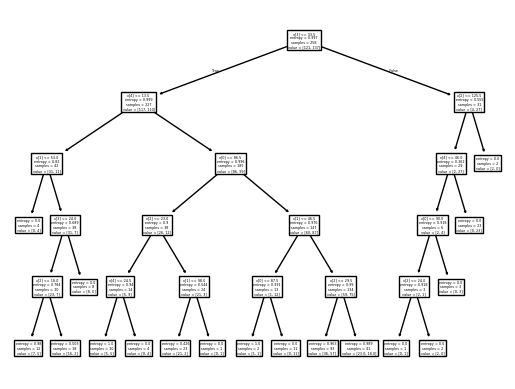

In [12]:
plot_tree(dt)